In [1]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import numpy as np
import rasterio
from rasterio.transform import from_origin

In [3]:
import matplotlib.pyplot as plt

In [4]:
from scipy.interpolate import RegularGridInterpolator

In [5]:
from scipy.interpolate import griddata

In [6]:
import hdbscan

In [7]:
from sklearn.decomposition import PCA

In [8]:
from sklearn.neighbors import NearestNeighbors

In [9]:
from itertools import permutations

In [10]:
import networkx as nx

In [11]:
from itertools import combinations

In [12]:
import string

In [13]:
from scipy.spatial.transform import Rotation as R

In [14]:
import laspy

In [52]:
from scipy.ndimage import gaussian_filter

In [1080]:
#Input
tls_origin = "F:/Fusion/experiments/OBJ tochigi1-2/FUSION OBJtochigi1-2 tls.pcd"
dls_origin = "F:/Fusion/experiments/OBJ tochigi1-2/FUSION OBJtochigi1-2 dls.pcd"
tls_g = "F:/Fusion/experiments/OBJ tochigi1-2/FUSION OBJtochigi1-2 tls gruond.pcd"
tls_og = "F:/Fusion/experiments/OBJ tochigi1-2/FUSION OBJtochigi1-2 tls offgruond.pcd"
dls_g = "F:/Fusion/experiments/OBJ tochigi1-2/FUSION OBJtochigi1-2 dls gruond.pcd"
dls_og = "F:/Fusion/experiments/OBJ tochigi1-2/FUSION OBJtochigi1-2 dls offgruond.pcd"
tls_stems = "F:/Fusion/experiments/OBJ tochigi1-2/FUSION OBJtochigi1-2 tls stems.pcd"
dls_stems = "F:/Fusion/experiments/OBJ tochigi1-2/FUSION OBJtochigi1-2 dls stems.pcd"
#Output
tls_dem = "F:/Fusion/experiments/OBJ tochigi1-2/FUSION OBJtochigi1-2 tls dem.tif"
dls_dem = "F:/Fusion/experiments/OBJ tochigi1-2/FUSION OBJtochigi1-2 dls dem.tif"
tls_dem_filled = "F:/Fusion/experiments/OBJ tochigi1-2/filled_FUSION OBJtochigi1-2 tls dem.tif"
dls_dem_filled = "F:/Fusion/experiments/OBJ tochigi1-2/filled_FUSION OBJtochigi1-2 dls dem.tif"
tls_coarse_result = "F:/Fusion/experiments/OBJ tochigi1-2/FUSION OBJtochigi1-2 tls result.pcd"
dls_coarse_result = "F:/Fusion/experiments/OBJ tochigi1-2/FUSION OBJtochigi1-2 dls result.pcd"

# load the ground points and calculate DEM

In [219]:
def filter_points_based_on_normalized_elevation(ground_pcd_path, offground_pcd_path, resolution, sigma, elevation_min, elevation_max):
    # Load ground points
    ground_pcd = o3d.io.read_point_cloud(ground_pcd_path)
    ground_points = np.asarray(ground_pcd.points)
    
    # Generate a smoothed DTM
    x_min, y_min = np.min(ground_points, axis=0)[:2]
    x_max, y_max = np.max(ground_points, axis=0)[:2]
    x_grid = np.arange(x_min, x_max, resolution)
    y_grid = np.arange(y_min, y_max, resolution)
    x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
    z_values = griddata(ground_points[:, :2], ground_points[:, 2], (x_mesh, y_mesh), method='linear')
    z_values_smoothed = gaussian_filter(z_values, sigma=sigma)
    
    # Load off-ground points
    offground_pcd = o3d.io.read_point_cloud(offground_pcd_path)
    offground_points = np.asarray(offground_pcd.points)
    
    # Calculate normalized elevation for off-ground points
    normalized_elevation = []
    for point in offground_points:
        idx_x = (np.abs(x_mesh[0] - point[0])).argmin()
        idx_y = (np.abs(y_mesh[:,0] - point[1])).argmin()
        elevation_diff = point[2] - z_values_smoothed[idx_y, idx_x]
        normalized_elevation.append(elevation_diff)
    normalized_elevation = np.array(normalized_elevation)
    
    # Filter points based on normalized elevation
    indices_in_range = (normalized_elevation >= elevation_min) & (normalized_elevation <= elevation_max)
    filtered_points = offground_points[indices_in_range]
    
    # Package DTM data and filtered points into a dictionary for return
    return {
        "dtm_data": {
            "x_mesh": x_mesh,
            "y_mesh": y_mesh,
            "z_values_smoothed": z_values_smoothed
        },
        "filtered_points": filtered_points
    }

In [1070]:
tls_results = filter_points_based_on_normalized_elevation(tls_g, tls_og, resolution=.5, 
                                                                  sigma=1, elevation_min=4.5, elevation_max=5)

tls_dtm_data = tls_results["dtm_data"]
tls_filtered_points = tls_results["filtered_points"]

In [1081]:
tls_results = filter_points_based_on_normalized_elevation(tls_g, tls_og, resolution=.5, 
                                                                  sigma=1, elevation_min=4.5, elevation_max=5)

tls_dtm_data = tls_results["dtm_data"]
tls_filtered_points = tls_results["filtered_points"]

dls_results = filter_points_based_on_normalized_elevation(dls_g, dls_og, resolution=.5, 
                                                                  sigma=1, elevation_min=7.5, elevation_max=8.5)

dls_dtm_data = dls_results["dtm_data"]
dls_filtered_points = dls_results["filtered_points"]



In [1071]:
dls_results = filter_points_based_on_normalized_elevation(dls_g, dls_og, resolution=.5, 
                                                                  sigma=1, elevation_min=7.5, elevation_max=8.5)

dls_dtm_data = dls_results["dtm_data"]
dls_filtered_points = dls_results["filtered_points"]

In [1083]:
tls_filtered_pcd = o3d.geometry.PointCloud()
tls_filtered_pcd.points = o3d.utility.Vector3dVector(tls_filtered_points)
o3d.visualization.draw_geometries([tls_filtered_pcd], window_name="Filtered Point Cloud", width=800, height=600)
o3d.io.write_point_cloud(tls_stems, tls_filtered_pcd)


dls_filtered_pcd = o3d.geometry.PointCloud()
dls_filtered_pcd.points = o3d.utility.Vector3dVector(dls_filtered_points)
o3d.visualization.draw_geometries([dls_filtered_pcd], window_name="Filtered Point Cloud", width=800, height=600)
o3d.io.write_point_cloud(dls_stems, dls_filtered_pcd)

True

# Stem clustering

In [1247]:
def apply_hdbscan_and_visualize(file_path):
    # Read the point cloud
    pcd = o3d.io.read_point_cloud(file_path)
    points = np.asarray(pcd.points)

    # Apply HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=100, cluster_selection_epsilon=0.5)
    labels = clusterer.fit_predict(points)

    # Generate random colors for each cluster label
    unique_labels = np.unique(labels)
    np.random.seed(42)  # For reproducible colors; remove for completely random colors
    random_colors = np.random.rand(len(unique_labels), 3)
    label_to_color = {label: random_colors[i] for i, label in enumerate(unique_labels)}

    # Assign a random color to each point based on its cluster label
    point_colors = np.array([label_to_color[label] if label != -1 else [0, 0, 0] for label in labels])

    # Create a new point cloud for visualization
    clustered_pcd = o3d.geometry.PointCloud()
    clustered_pcd.points = o3d.utility.Vector3dVector(points)
    clustered_pcd.colors = o3d.utility.Vector3dVector(point_colors)
    
    labels = clusterer.fit_predict(points)
    

    # Visualize the clustered point cloud
    o3d.visualization.draw_geometries([clustered_pcd], window_name="Clustered Point Cloud", width=800, height=600)
    #return labels
    return labels, clustered_pcd
    


In [1248]:
# Apply clustering and visualize
dls_clusters, dls_clusters_fig = apply_hdbscan_and_visualize(dls_stems)
tls_clusters, tls_clusters_fig = apply_hdbscan_and_visualize(tls_stems)

# Point counts and linearity

In [96]:
def analyze_clusters(points, labels):
    clusters_data = {}
    total_points = len(points[labels != -1])  # Excluding noise points
    z_axis = np.array([0, 0, 1])  # Z-axis unit vector

    for label in np.unique(labels):
        if label == -1:  # Skip noise
            continue
        
        # Cluster-specific points
        cluster_points = points[labels == label]

        # Count points in the cluster
        count = len(cluster_points)

        # Normalized count     
        normalized_count = count / total_points

        # PCA for linearity and vertical alignment
        if len(cluster_points) > 1:
            pca = PCA(n_components=min(3, len(cluster_points)))
            pca.fit(cluster_points)
            linearity = pca.explained_variance_ratio_[0]
            pc1 = pca.components_[0]  # First principal component
            vertical_alignment = abs(np.dot(pc1, z_axis))  # Alignment with Z-axis
        else:
            linearity = 1
            vertical_alignment = 1 if np.dot(cluster_points[0], z_axis) > 0 else 0

        # Store in dictionary
        clusters_data[label] = {
            'count': count,
            'normalized_count': normalized_count,
            'linearity': linearity,
            'vertical_alignment': vertical_alignment
        }

    return clusters_data

In [1250]:
clusters_info_dls = analyze_clusters(dls_filtered_points, dls_clusters)
clusters_info_tls = analyze_clusters(tls_filtered_points, tls_clusters)

In [486]:
def calculate_weighted_score(cluster_data, linearity_weight=0.4, count_weight=0.1, vertical_alignment_weight=0.5):
    # Normalize the linearity, counts, and vertical alignment to be on the same scale
    max_linearity = max(cluster['linearity'] for cluster in cluster_data.values())
    max_count = max(cluster['normalized_count'] for cluster in cluster_data.values())
    max_vertical_alignment = max(cluster['vertical_alignment'] for cluster in cluster_data.values())

    for label, data in cluster_data.items():
        normalized_linearity = data['linearity'] / max_linearity
        normalized_count = data['normalized_count'] / max_count
        normalized_vertical_alignment = data['vertical_alignment'] / max_vertical_alignment

        # Calculate weighted score
        score = (linearity_weight * normalized_linearity) + \
                (count_weight * normalized_count) + \
                (vertical_alignment_weight * normalized_vertical_alignment)
        cluster_data[label]['score'] = score

    return cluster_data

In [1251]:
# Apply the scoring function
clusters_info_dls = calculate_weighted_score(clusters_info_dls)
clusters_info_tls = calculate_weighted_score(clusters_info_tls)

# Sort clusters by score
sorted_clusters_dls = sorted(clusters_info_dls.items(), key=lambda x: x[1]['score'], reverse=True)
sorted_clusters_tls = sorted(clusters_info_tls.items(), key=lambda x: x[1]['score'], reverse=True)

In [920]:
def visualize_top_clusters(original_points, labels, sorted_clusters_info, top_percentage=.5):
    # Determine the number of clusters to include (top 30%)
    num_top_clusters = int(len(sorted_clusters_info) * top_percentage)

    # Get the labels of the top clusters
    top_cluster_labels = [cluster[0] for cluster in sorted_clusters_info[:num_top_clusters]]

    # Filter points that belong to the top clusters
    top_points = original_points[np.isin(labels, top_cluster_labels)]

    # Create a point cloud for visualization
    top_clusters_pcd = o3d.geometry.PointCloud()
    top_clusters_pcd.points = o3d.utility.Vector3dVector(top_points)

    # Visualize the point cloud
    o3d.visualization.draw_geometries([top_clusters_pcd], window_name="Top Clusters Point Cloud", width=800, height=600)


In [1090]:
def visualize_and_record_top_clusters(original_points, labels, sorted_clusters_info, top_percentage=.8):
    # Determine the number of clusters to include (top 30%)
    num_top_clusters = int(len(sorted_clusters_info) * top_percentage)

    # Get the labels of the top clusters
    top_cluster_labels = [cluster[0] for cluster in sorted_clusters_info[:num_top_clusters]]

    # Filter points that belong to the top clusters
    top_clusters_points = []
    for label in top_cluster_labels:
        cluster_points = original_points[labels == label]
        top_clusters_points.append(cluster_points)

    # Create and visualize a point cloud for the top clusters
    top_clusters_pcd = o3d.geometry.PointCloud()
    top_clusters_pcd.points = o3d.utility.Vector3dVector(np.concatenate(top_clusters_points, axis=0))
    o3d.visualization.draw_geometries([top_clusters_pcd], window_name="Top Clusters Point Cloud", width=800, height=600)

    # Return the list of points in the top clusters
    return top_clusters_points

In [ ]:
top_clusters_dls = visualize_and_record_top_clusters(dls_filtered_points, dls_clusters, sorted_clusters_dls)
top_clusters_tls = visualize_and_record_top_clusters(tls_filtered_points, tls_clusters, sorted_clusters_tls)

# Graph network

In [104]:
def calculate_centroid(cluster_points):
    # Check if cluster_points is 2-dimensional; if not, return the point itself
    if cluster_points.ndim == 1:
        return cluster_points
    else:
        return np.mean(cluster_points, axis=0)

def project_to_xy(centroid):
    # Assuming centroid is a 1-dimensional array representing a single point
    return centroid[:2]

def calculate_angle(v1, v2):
    # Calculate the angle in radians between vectors 'v1' and 'v2'
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.arccos(np.clip(cos_theta, -1, 1))  # Clip cos_theta for numerical stability
    return angle

In [105]:
def construct_graph_features(clusters, k=5):
    # Initialize dictionaries
    graph_features = {}
    node_to_node_distances = {}

    # Calculate centroids and project onto the XY plane
    centroids = np.array([calculate_centroid(cluster) for cluster in clusters])
    nodes = np.array([project_to_xy(centroid) for centroid in centroids])

    # Use kNN to find k nearest neighbors for each node
    knn = NearestNeighbors(n_neighbors=k+1)  # k+1 because the node itself is included
    knn.fit(nodes)
    distances, indices = knn.kneighbors(nodes)

    # Construct features for each cluster
    for i, (centroid, neighbors_idx) in enumerate(zip(centroids, indices)):
        # Exclude the node itself from its neighbors
        neighbor_indices = neighbors_idx[1:]
        neighbor_nodes = nodes[neighbor_indices]

        # Calculate and store distances between node pairs
        for j, neighbor_idx in enumerate(neighbor_indices):
            node_to_node_distances[(i, neighbor_idx)] = distances[i][j+1]  # j+1 to skip the distance to itself

        # Generate all unique combinations of neighbor pairs and calculate angles
        neighbor_combinations = list(combinations(neighbor_indices, 2))
        angles = []
        for (n1, n2) in neighbor_combinations:
            vector1 = nodes[n1] - centroid[:2]
            vector2 = nodes[n2] - centroid[:2]
            angle = np.arctan2(vector2[1], vector2[0]) - np.arctan2(vector1[1], vector1[0])
            angles.append(np.mod(angle, 2 * np.pi))  # Ensure the angle is within [0, 2π)

        # Record the features for the axis node
        graph_features[i] = {
            'combinations': neighbor_combinations,
            'angles': angles
        }

    return graph_features, node_to_node_distances

In [1256]:
# Now call construct_graph_features with the clusters
dls_graph_features, dls_node_to_node_distances = construct_graph_features(top_clusters_dls, k=9)
tls_graph_features, tls_node_to_node_distances = construct_graph_features(top_clusters_tls, k=4)

In [855]:
def visualize_graph(nodes, graph_features):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes to the graph
    for i, node in enumerate(nodes):
        G.add_node(i, pos=(node[0], node[1]))

    # Add edges to the graph based on the graph_features 'sets'
    for i, features in graph_features.items():
        for (n1, n2) in features['combinations']:
            G.add_edge(n1, n2)

    # Draw the graph
    pos = nx.get_node_attributes(G, 'pos')
    fig, ax = plt.subplots()
    #nx.draw(G, pos, ax=ax, with_labels=False, node_color='pink', 
    #        node_size=200, edge_color='gray', font_size=8)
    nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue', 
            node_size=200, edge_color='gray', font_size=8)

    # Display the graph
    plt.show()

In [653]:
def visualize_graph(nodes, graph_features):
    # 创建一个无向图
    G = nx.Graph()

    # 向图中添加节点
    for i, node in enumerate(nodes):
        G.add_node(i, pos=(node[0], node[1]))

    # 根据 graph_features 中的 'combinations' 向图中添加边
    for i, features in graph_features.items():
        for (n1, n2) in features['combinations']:
            G.add_edge(n1, n2)

    # 绘制图形
    pos = nx.get_node_attributes(G, 'pos')
    fig, ax = plt.subplots()

    # 去除黑色边框
    for spine in ax.spines.values():
        spine.set_visible(False)

    # 首先绘制所有的边
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='orange')

    # 然后绘制特定的边（使用橙色）
    #special_edges = [(1, 2), (1, 6), (0, 1), (2, 6), (2,0), (6,0)]
    #nx.draw_networkx_edges(G, pos, ax=ax, edgelist=special_edges, edge_color='orange')

    # 绘制节点
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='pink', node_size=200)

    # 显示图形
    plt.show()

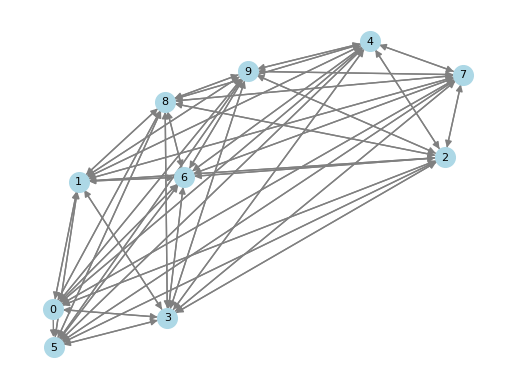

In [1257]:
# Assuming 'dls_graph_features' is your graph features and 'dls_clusters' contains the clusters
dls_centroids = np.array([calculate_centroid(cluster) for cluster in top_clusters_dls if cluster.ndim > 1 and len(cluster) > 0])
dls_nodes = np.array([project_to_xy(centroid) for centroid in dls_centroids])
visualize_graph(dls_nodes, dls_graph_features)

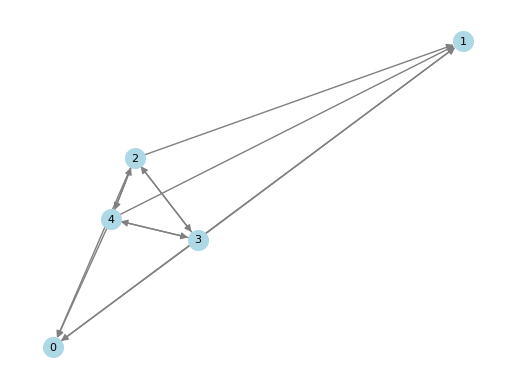

In [1258]:
# Assuming 'dls_graph_features' is your graph features and 'dls_clusters' contains the clusters
tls_centroids = np.array([calculate_centroid(cluster) for cluster in top_clusters_tls if cluster.ndim > 1 and len(cluster) > 0])
tls_nodes = np.array([project_to_xy(centroid) for centroid in tls_centroids])
visualize_graph(tls_nodes, tls_graph_features)

In [1259]:
dls_graph_features

{0: {'combinations': [(5, 3),
   (5, 1),
   (5, 6),
   (5, 8),
   (5, 2),
   (5, 9),
   (5, 7),
   (5, 4),
   (3, 1),
   (3, 6),
   (3, 8),
   (3, 2),
   (3, 9),
   (3, 7),
   (3, 4),
   (1, 6),
   (1, 8),
   (1, 2),
   (1, 9),
   (1, 7),
   (1, 4),
   (6, 8),
   (6, 2),
   (6, 9),
   (6, 7),
   (6, 4),
   (8, 2),
   (8, 9),
   (8, 7),
   (8, 4),
   (2, 9),
   (2, 7),
   (2, 4),
   (9, 7),
   (9, 4),
   (7, 4)],
  'angles': [1.3985283258278212,
   3.0402489241598056,
   2.699367499472569,
   2.8867425130302085,
   2.256102652779359,
   2.7688936636339547,
   2.4493059917762654,
   2.6292244238581546,
   1.6417205983319845,
   1.300839173644748,
   1.4882141872023873,
   0.8575743269515377,
   1.3703653378061336,
   1.050777665948444,
   1.2306960980303332,
   5.94230388249235,
   6.129678896049989,
   5.499039035799139,
   6.011830046653735,
   5.692242374796046,
   5.872160806877935,
   0.1873750135576393,
   5.8399204604863755,
   0.06952616416138557,
   6.033123799483282,
   6.21304

# Label matching

In [515]:
def is_within_threshold(value1, value2, threshold):
    return abs(value1 - value2) <= threshold

def angle_difference(angle1, angle2):
    # Calculate the absolute difference between two angles and account for circularity
    return min(abs(angle1 - angle2), 2 * np.pi - abs(angle1 - angle2))


In [516]:
def match_sets(dls_features, tls_features, dls_node_to_node_distances, tls_node_to_node_distances, distance_threshold, angle_threshold_degrees):
    angle_threshold = np.radians(angle_threshold_degrees)  # Convert angle threshold to radians
    matches = []

    # Iterate over each feature set in DLS
    for dls_axis, dls_data in dls_features.items():
        dls_combinations = dls_data['combinations']
        dls_angles = dls_data['angles']

        # Iterate over each feature set in TLS
        for tls_axis, tls_data in tls_features.items():
            tls_combinations = tls_data['combinations']
            tls_angles = tls_data['angles']

            # Check each combination of neighbors in DLS against all combinations in TLS
            for dls_combination_index, dls_combination in enumerate(dls_combinations):
                for tls_combination_index, tls_combination in enumerate(tls_combinations):
                    # Retrieve distances for the DLS combination from the distances dictionary
                    dls_distances = [dls_node_to_node_distances[(dls_axis, neighbor)] for neighbor in dls_combination]
                    tls_distances = [tls_node_to_node_distances[(tls_axis, neighbor)] for neighbor in tls_combination]

                    # Compare distances and angles for the current combination pair
                    distance_matches = all(is_within_threshold(d_dls, d_tls, distance_threshold) for d_dls, d_tls in zip(dls_distances, tls_distances))
                    angle_matches = angle_difference(dls_angles[dls_combination_index], tls_angles[tls_combination_index]) <= angle_threshold

                    # If a match is found, add the matching nodes to the list
                    if distance_matches and angle_matches:
                        matches.append({
                            'dls_axis': dls_axis,
                            'tls_axis': tls_axis,
                            'dls_combination': dls_combination,
                            'tls_combination': tls_combination,
                        })
                        # Break once a match is found to avoid multiple matches for the same DLS node
                        break

    return matches

In [1260]:
# Example usage
distance_threshold = .5# Example threshold for distance
angle_threshold = 10    # Example threshold for angles in degrees

In [1261]:
dls_node_to_node_distances

{(0, 5): 1.3875473642831502,
 (0, 3): 1.9739041448220829,
 (0, 1): 4.6725712486802005,
 (0, 6): 5.311009690631714,
 (0, 8): 7.802349457780266,
 (0, 2): 8.67385916053722,
 (0, 9): 9.290095021674588,
 (0, 7): 11.041400505721974,
 (0, 4): 11.160594794507157,
 (1, 6): 1.8064936941300624,
 (1, 8): 3.2638792100234224,
 (1, 0): 4.6725712486802005,
 (1, 9): 4.94957551953716,
 (1, 3): 5.199655917455801,
 (1, 5): 6.054626853790159,
 (1, 2): 6.299211498943426,
 (1, 4): 7.1260908382642665,
 (1, 7): 7.619729735064043,
 (2, 7): 3.0280457644514596,
 (2, 4): 4.416498310623207,
 (2, 6): 4.495878694714663,
 (2, 9): 4.594412054431815,
 (2, 8): 5.176352065501709,
 (2, 1): 6.299211498943426,
 (2, 3): 7.5317996747623095,
 (2, 0): 8.67385916053722,
 (2, 5): 9.612271494947025,
 (3, 0): 1.9739041448220829,
 (3, 5): 2.2096608316414814,
 (3, 6): 5.148928997036587,
 (3, 1): 5.199655917455801,
 (3, 2): 7.5317996747623095,
 (3, 8): 7.888734689450519,
 (3, 9): 9.104964154307453,
 (3, 7): 10.205363457230334,
 (3, 4):

In [1262]:
# Assuming 'dls_graph_features', 'tls_graph_features', 'dls_node_to_node_distances', and 'tls_node_to_node_distances' are defined
matched_sets = match_sets(dls_graph_features, tls_graph_features, dls_node_to_node_distances, tls_node_to_node_distances, distance_threshold, angle_threshold)

# Output matched sets
print(matched_sets)

[{'dls_axis': 0, 'tls_axis': 4, 'dls_combination': (3, 2), 'tls_combination': (3, 1)}, {'dls_axis': 1, 'tls_axis': 0, 'dls_combination': (0, 3), 'tls_combination': (3, 2)}, {'dls_axis': 1, 'tls_axis': 2, 'dls_combination': (5, 4), 'tls_combination': (0, 1)}, {'dls_axis': 1, 'tls_axis': 2, 'dls_combination': (5, 7), 'tls_combination': (0, 1)}, {'dls_axis': 2, 'tls_axis': 1, 'dls_combination': (3, 0), 'tls_combination': (3, 4)}, {'dls_axis': 2, 'tls_axis': 3, 'dls_combination': (7, 6), 'tls_combination': (2, 0)}, {'dls_axis': 3, 'tls_axis': 1, 'dls_combination': (8, 9), 'tls_combination': (3, 4)}, {'dls_axis': 3, 'tls_axis': 2, 'dls_combination': (0, 5), 'tls_combination': (4, 3)}, {'dls_axis': 3, 'tls_axis': 3, 'dls_combination': (0, 2), 'tls_combination': (4, 1)}, {'dls_axis': 3, 'tls_axis': 3, 'dls_combination': (5, 8), 'tls_combination': (4, 1)}, {'dls_axis': 4, 'tls_axis': 0, 'dls_combination': (8, 6), 'tls_combination': (3, 2)}, {'dls_axis': 4, 'tls_axis': 1, 'dls_combination': (1,

In [1197]:
def standardize_match(match):
    # Create a standardized representation of the match with axis node pair first
    # Followed by the sorted branch node pairs
    branch_pairs = tuple(sorted([(match['dls_combination'][i], match['tls_combination'][i]) for i in range(2)]))
    standardized_match = ((match['dls_axis'], match['tls_axis']),) + branch_pairs
    return standardized_match

def record_matches(matched_sets):
    recorded_matches = []

    # Record each match in the standardized format
    for match in matched_sets:
        standardized = standardize_match(match)
        recorded_matches.append(standardized)

    return recorded_matches

def find_complete_patterns(recorded_matches):
    # Create a dictionary to group matches by the set of all involved nodes
    patterns = {}

    # Iterate over the recorded matches and group by the involved nodes
    for match in recorded_matches:
        # Create a key based on the involved nodes, disregarding the order
        nodes = frozenset(match)

        # Add the match to the patterns dictionary
        patterns.setdefault(nodes, [])
        patterns[nodes].append(match)

    # Find patterns that appear in all permutations
    complete_patterns = []
    for nodes, matches in patterns.items():
        if len(matches) == 3:
            # Verify that the matches are permutations of each other
            match_sets = [frozenset(m) for m in matches]
            if len(set(match_sets)) == 1:
                # Store only the first match of the group
                complete_patterns.append(matches[0])
                
    # Use a set to ensure uniqueness
    unique_patterns = set(frozenset(match) for match in complete_patterns)
    
    # Convert back to a list of tuples for the final output
    complete_patterns = [tuple(pattern) for pattern in unique_patterns]

    return complete_patterns

In [1263]:
# Example usage
recorded_matches = record_matches(matched_sets)
complete_patterns = find_complete_patterns(recorded_matches)

# Output complete patterns
for pattern_group in complete_patterns:
    print("Complete pattern group found:")
    for pattern in pattern_group:
        print(f"  Match: {pattern}")

Complete pattern group found:
  Match: (6, 2)
  Match: (4, 0)
  Match: (8, 3)
Complete pattern group found:
  Match: (3, 3)
  Match: (0, 4)
  Match: (2, 1)
Complete pattern group found:
  Match: (2, 3)
  Match: (7, 2)
  Match: (6, 0)
Complete pattern group found:
  Match: (5, 4)
  Match: (3, 3)
  Match: (8, 1)
Complete pattern group found:
  Match: (1, 2)
  Match: (5, 0)
  Match: (7, 1)
Complete pattern group found:
  Match: (5, 0)
  Match: (1, 2)
  Match: (4, 1)


# Maximize combination selection 

In [122]:
import pulp

In [1264]:
# 数据预处理，确保每个点对只记录一次
point_pairs = set()
for pattern in complete_patterns:
    for pair in pattern:
        point_pairs.add(pair)  # Add each pair to the set

In [1265]:
for cc, cpattern in enumerate(complete_patterns):
    print(cc, cpattern)

0 ((6, 2), (4, 0), (8, 3))
1 ((3, 3), (0, 4), (2, 1))
2 ((2, 3), (7, 2), (6, 0))
3 ((5, 4), (3, 3), (8, 1))
4 ((1, 2), (5, 0), (7, 1))
5 ((5, 0), (1, 2), (4, 1))


In [1266]:
complete_patterns

[((6, 2), (4, 0), (8, 3)),
 ((3, 3), (0, 4), (2, 1)),
 ((2, 3), (7, 2), (6, 0)),
 ((5, 4), (3, 3), (8, 1)),
 ((1, 2), (5, 0), (7, 1)),
 ((5, 0), (1, 2), (4, 1))]

In [1267]:

def optimize_graph_matching(complete_patterns):
    # 创建一个新的线性规划问题
    prob = pulp.LpProblem("GraphMatching", pulp.LpMaximize)
    
    # 初始化决策变量
    y_vars = {}  # y变量对应完整模式组中的匹配
    x_vars = {}  # x变量对应所有可能的点对匹配
    z_vars = {}
    
    # 先创建所有可能的x变量，确保它们是唯一的
    unique_mn_pairs = set(pair for pattern in complete_patterns for pair in pattern)
    for m, n in unique_mn_pairs:
        x_vars[(m, n)] = pulp.LpVariable(f"x_{m}_{n}", cat='Binary')
    
    # 对于complete_patterns中的每一个模式（c），构建y变量
    for c, pattern in enumerate(complete_patterns):
        for m, n in pattern: 
            y_vars[(m, n, c)] = pulp.LpVariable(f"y_{m}_{n}_{c}", cat='Binary')
    
    # 目标函数是最大化所有y变量的总和
    prob += pulp.lpSum(y_vars.values())
    
    # 约束条件: 对于每个c, y_mn^c <= x_mn
    for (m, n, c), y_var in y_vars.items():
        prob += y_var <= x_vars[(m, n)]
        
    for m, n in unique_mn_pairs:
        # 确保 x_vars[(m, n)] 的值不超过所有相关 y_vars[(m, n, c)] 的总和
        prob += pulp.lpSum(y_vars[(m, n, c)] for c in range(len(complete_patterns)) if (m, n, c) in y_vars) >= x_vars[(m, n)]

    
    # 约束条件: 每个节点m和n在所有模式组中最多只能匹配一次
    for m in set(pair[0] for pair in unique_mn_pairs):
        prob += pulp.lpSum(x_vars[(m, n)] for n in set(pair[1] for pair in unique_mn_pairs) if (m, n) in x_vars) <= 1

    for n in set(pair[1] for pair in unique_mn_pairs):
        prob += pulp.lpSum(x_vars[(m, n)] for m in set(pair[0] for pair in unique_mn_pairs) if (m, n) in x_vars) <= 1
        
    #约束条件： 保持每个c和其中包含的点对决策上的一致性
    for c, pattern in enumerate(complete_patterns):
        # 对于pattern中的任意两对不同的点对配对(m1, n1), (m2, n2)
        for i, (m1, n1) in enumerate(pattern):
            for j, (m2, n2) in enumerate(pattern):
                if i < j:  # 确保我们不是在比较同一对
                    # 添加约束：保持模式组中的决策一致性
                    prob += y_vars[(m1, n1, c)] == y_vars[(m2, n2, c)]


    # 求解问题
    prob.solve()

    # 获取结果
    matched_x_pairs = [k for k, v in x_vars.items() if v.varValue == 1]
    matched_y_patterns = [(m, n, c) for (m, n, c), v in y_vars.items() if v.varValue == 1]


    return matched_x_pairs, matched_y_patterns


In [1268]:
# 使用示例
matched_x_pairs, matched_y_patterns = optimize_graph_matching(complete_patterns)

# 打印结果
print("Matched x Pairs:")
for pair in matched_x_pairs:
    print(f"Matched DLS node {pair[0]} with TLS node {pair[1]}")

print("\nMatched y Triangle Pairs:")
for (m, n, c) in matched_y_patterns:
    print(f"Matched Triangle pattern {c} with DLS node {m} and TLS node {n}")

Matched x Pairs:
Matched DLS node 0 with TLS node 4
Matched DLS node 2 with TLS node 1
Matched DLS node 3 with TLS node 3

Matched y Triangle Pairs:
Matched Triangle pattern 1 with DLS node 3 and TLS node 3
Matched Triangle pattern 1 with DLS node 0 and TLS node 4
Matched Triangle pattern 1 with DLS node 2 and TLS node 1


In [1269]:
matched_x_pairs

[(0, 4), (2, 1), (3, 3)]

# Coarse alignment

In [212]:
def get_elevation_at_points(dem_file, points_2d):
    with rasterio.open(dem_file) as dem:
        # Get the indices of the points in the DEM's grid
        row_indices, col_indices = dem.index(points_2d[:, 0], points_2d[:, 1])

        # Read the elevation data
        elevation_data = dem.read(1)

        # Extract the elevation for each point
        elevations = elevation_data[row_indices, col_indices]

    return elevations

def extract_3d_points(nodes, dem_file, pattern_indices):
    # Extract the 2D points (X, Y coordinates)
    points_2d = np.array([nodes[i] for i in pattern_indices])

    # Get the corresponding Z (elevation) values from the DEM
    elevations = get_elevation_at_points(dem_file, points_2d)

    # Combine X, Y, and Z to get 3D points
    points_3d = np.hstack((points_2d, elevations.reshape(-1, 1)))

    return points_3d

In [1217]:
complete_patterns

[((9, 6), (2, 1), (3, 4)),
 ((9, 6), (3, 4), (1, 5)),
 ((9, 0), (0, 2), (5, 1)),
 ((2, 1), (3, 4), (1, 5)),
 ((9, 0), (0, 2), (4, 1)),
 ((9, 0), (4, 1), (7, 2)),
 ((2, 3), (4, 5), (5, 4)),
 ((9, 0), (5, 1), (7, 2)),
 ((7, 0), (9, 2), (1, 5)),
 ((6, 2), (3, 3), (7, 5)),
 ((6, 2), (1, 3), (0, 5)),
 ((8, 2), (9, 1), (5, 0)),
 ((8, 2), (9, 1), (2, 6))]

In [223]:
def get_z_elevation_from_dtm(nodes, dtm_data, pattern_indices):
    
    # Extract the 2D points (X, Y coordinates)
    points_2d = np.array([nodes[i] for i in pattern_indices])

    
    # Extract the DTM components directly from dtm_data
    x_mesh = dtm_data['x_mesh']
    y_mesh = dtm_data['y_mesh']
    z_values_smoothed = dtm_data['z_values_smoothed']
    
    # Initialize an empty list to hold the 3D points
    points_3d = []

    for point in points_2d:
        # Find the closest indices for each 2D point in the DTM grid
        idx_x = np.abs(x_mesh[0] - point[0]).argmin()
        idx_y = np.abs(y_mesh[:,0] - point[1]).argmin()
        
        # Extract the Z elevation for the closest point
        z_elevation = z_values_smoothed[idx_y, idx_x]
        
        # Append the 3D point to the list
        points_3d.append([point[0], point[1], z_elevation])
    
    # Convert the list of 3D points into a NumPy array
    return np.array(points_3d)


In [1270]:
dls_indices = [index[0] for index in matched_x_pairs]
tls_indices = [index[1] for index in matched_x_pairs]

dls_3d_points = get_z_elevation_from_dtm(dls_nodes,dls_dtm_data , dls_indices)
tls_3d_points = get_z_elevation_from_dtm(tls_nodes,tls_dtm_data , tls_indices)

In [771]:
def find_rigid_body_transformation(src_points, dst_points):
    # Calculate centroids
    src_centroid = np.mean(src_points, axis=0)
    dst_centroid = np.mean(dst_points, axis=0)

    # Center the points around the centroids
    src_centered = src_points - src_centroid
    dst_centered = dst_points - dst_centroid

    # Compute the covariance matrix
    H = src_centered.T @ dst_centered

    # Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(H)

    # Compute rotation
    R = Vt.T @ U.T

    # Special reflection case handling
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    # Compute translation
    t = dst_centroid - R @ src_centroid

    return R, t

In [1311]:
# Assuming dls_3d_points and tls_3d_points are the extracted 3D points
rotation_matrix, translation_vector = find_rigid_body_transformation(dls_3d_points, tls_3d_points)

# Output the transformation parameters
print("Rotation Matrix:")
print(rotation_matrix)
print("\nTranslation Vector:")
print(translation_vector)
# Combine into a 4x4 transformation matrix
transformation_matrix = np.eye(4)  # Start with an identity matrix
transformation_matrix[:3, :3] = rotation_matrix  # Insert the rotation matrix
transformation_matrix[:3, 3] = translation_vector  # Insert the translation vector

Rotation Matrix:
[[ 0.95031635  0.24783111 -0.18835759]
 [-0.18754684  0.93878511  0.28897871]
 [ 0.24844522 -0.23929533  0.93862278]]

Translation Vector:
[-2.82786339 -2.27359815  7.21861325]
